In [177]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp

from scipy.optimize import differential_evolution

# General imports
import os
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp

# custom module
from susy_qm import calculate_Hamiltonian, create_vqe_plots

In [293]:
potential = 'QHO'
#potential = 'AHO'
#potential = 'DW'
cut_off = 4

In [294]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cut_off, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [295]:
num_qubits

3

In [296]:
#Initial params shape
num_layers = 2
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)

In [297]:
def ansatz(params, wires):
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    qml.StronglyEntanglingLayers(weights=params, wires=wires, imprimitive=qml.CZ)

In [298]:
# Device
shots = None
dev = qml.device('lightning.qubit', wires=2*num_qubits+1, shots=shots)

@qml.qnode(dev)
def swap_test(params1, params2):

    params1 = pnp.tensor(params1.reshape(params_shape), requires_grad=True)
    params2 = pnp.tensor(params2.reshape(params_shape), requires_grad=True)

    ancilla = 2*num_qubits
    qml.Hadamard(wires=ancilla)

    ansatz(params1, wires=range(num_qubits))
    ansatz(params2, wires=range(num_qubits, 2*num_qubits))

    qml.Barrier()  # added to better visualise the circuit
    for i in range(num_qubits):
        qml.CSWAP(wires=[ancilla, i, num_qubits + i])

    qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)
    #return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))
    #return qml.expval(qml.Z(ancilla))

In [299]:
# Example parameters for testing the swap test
params1 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))
params2 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))

# Run the swap test to get the probability of the ancilla being |0>
result = swap_test(params1, params2)

# The overlap is given by 2 * P(ancilla=0) - 1
#overlap = 2 * result[0] - 1

print(qml.draw(swap_test)(params1,params2))
print(f"\nOverlap between the ground state and the ansatz: {result}")

ValueError: cannot reshape array of size 9 into shape (2,3,3)

In [300]:
# Device
shots = None
dev2 = qml.device('lightning.qubit', wires=num_qubits, shots=shots)

@qml.qnode(dev2)
def expected_value(params):
    wires = range(num_qubits)
    ansatz(params, wires)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))


def loss_f(params):
    global prev_param_list, beta
    energy = expected_value(params)

    penalty = 0

    if len(prev_param_list) != 0:
        for prev_param in prev_param_list:
            overlap =  swap_test(prev_param, params)[0]
            penalty += (beta*overlap)

    return energy + penalty

In [301]:
def callback(xk, convergence=None):
    global iteration_counter, counts, values, steps, tol

    iteration_counter += 1

    current_value = loss_f(xk)

    counts.append(iteration_counter)
    values.append(current_value)           
    steps.append(xk.copy())  

    #return convergence < tol              

In [302]:
vqd_start = datetime.now()

#variables
num_vqd_runs = 2
max_iterations = 300
strategy = 'best1bin'
popsize = 15
tol = 1e-3

beta = 1.0

#data arrays
energies = []
prev_param_list = []

all_counts = []
all_values = []
all_steps = []
all_overlaps = []

for i in range(num_vqd_runs):

    run_start = datetime.now()

    iteration_counter = 0
    counts = []
    values = []
    steps = []

    if i % 1 == 0:
        print(f"Run: {i}")

    #Optimizer
    bounds = [(0, 2 * np.pi) for _ in range(np.prod(params_shape))]

    # Differential Evolution optimization
    res = differential_evolution(loss_f, 
                                    bounds, 
                                    maxiter=max_iterations, 
                                    atol=tol,
                                    strategy=strategy, 
                                    popsize=popsize,
                                    callback=callback)
    

    vqd_end = datetime.now()
    vqd_time = vqd_end - vqd_start
    
    print(res.success)
    energies.append(res.fun)
    prev_param_list.append(res.x) 
    print(energies)
    print(vqd_time)

    all_counts.append(counts)
    all_values.append(values)
    all_steps.append(steps)

    # Calculate overlap with all previous states
    overlaps = []
    if i > 0:
        for j in range(i):
            overlap = swap_test(prev_param_list[j], res.x)[0]
            overlaps.append(overlap)
        all_overlaps.append(overlaps)
        print(f"Overlaps with all previous states for run {i}: {overlaps}")

Run: 0
True
[3.4852338796363537e-12]
0:02:00.165313
Run: 1


KeyboardInterrupt: 

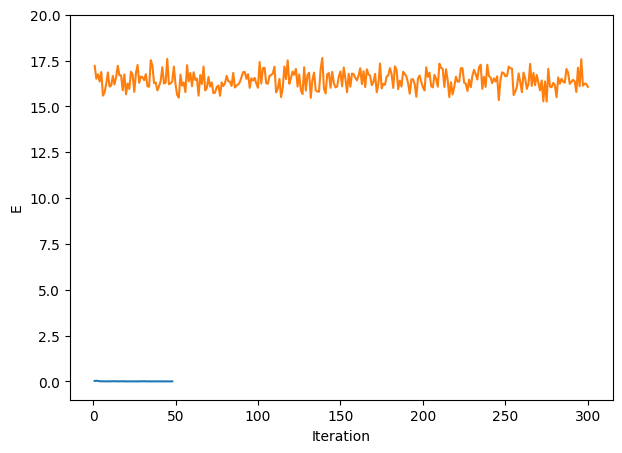

In [238]:
# Plotting each line for different states
plt.figure(figsize=(7, 5))  # Set figure size similar to the uploaded image

for i in range(num_vqd_runs):
    plt.plot(all_counts[i], all_values[i])# label=f"State {i}")

# Set axis labels and title
plt.xlabel("Iteration")
plt.ylabel("E")

# Set y-axis to logarithmic scale
#plt.yscale("log")
plt.ylim(-1.0, 20)

# Display legend
#plt.legend(loc="upper right")

# Show plot
plt.show()
#plt.savefig('VQD-AHO-16.png')
